In [1]:
# This notebook contains code to generate some extra diagrams, and to run PSO properly.

In [11]:
# This code is Performs PSO on a Discrete Graph
import pickle
import numpy as np
import random

# Loading the database
X = pickle.load(open('input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

# A function to return the index of the input in the database
def input_index(Xinput):
  for i, input in enumerate(X):
    if np.array_equal(Xinput, input):
      return y[i]
  return None

shape of X: (25877, 151)
shape of y: (25877,)


In [12]:
# Code for Particle Swarm Optimization: (See PSO_Discrete_Graph.ipynb for comments)

def objective_function(x):
    x = np.array(x)

    # Finding the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    return y[closest_index]

# snap_position essentially snaps the input to the point in the database closest to it
def snap_position(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    snapped_input = X[closest_index]
    return snapped_input

def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

class Particle:
    def __init__(self, num_dimensions, lower_bound, upper_bound, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.position)
        self.index = index
        self.positions_traversed = [closest_index(init_position)]

class PSO:
    def __init__(self, num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, init_positions):
        self.num_particles = num_particles
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.num_iterations = num_iterations
        self.particles = [Particle(num_dimensions, lower_bound, upper_bound, init_positions[ind], ind) for ind in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].position)
        self.global_best_fitness = self.particles[0].best_fitness
        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []
        init_pos_max = -1.0
        init_position_max = np.copy(self.particles[0].position)
        for init_pos in init_positions:
            self.unique_function_call_ids.append(closest_index(init_pos))
            if (y[closest_index(init_pos)] > init_pos_max):
                init_position_max = np.copy(init_pos)
                init_pos_max = y[closest_index(init_pos)]
            self.global_max_for_each_unique_function_call.append(init_pos_max)

        self.global_best_position = np.copy(init_position_max)
        self.global_best_fitness = init_pos_max

    def update_particles(self):
        for particle in self.particles:
            # Update velocities
            particle.velocity = (self.w * particle.velocity
                                + self.c1 * np.random.rand() * (particle.best_position - particle.position)
                                 + self.c2 * np.random.rand() * (self.global_best_position - particle.position))

            #print("particle #", particle.index, "'s velocity: ", np.linalg.norm(particle.velocity))

            if(np.linalg.norm(particle.velocity) > 1.5):
                #print("old norm: ", np.linalg.norm(particle.velocity))
                particle.velocity = ((particle.velocity / np.linalg.norm(particle.velocity)) * 1.5)
                #print("new norm: ", np.linalg.norm(particle.velocity))

            particle.position = particle.position + particle.velocity

            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = snap_position(particle.position)
            particle.positions_traversed.append(closest_index(particle.position))

    def update_personal_and_global_bests(self):
        for particle in self.particles:
            unique_function_called = False
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
                unique_function_called = True
            current_fitness = objective_function(particle.position)

            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                if current_fitness > self.global_best_fitness:
                    self.global_best_position = np.copy(particle.position)
                    self.global_best_fitness = current_fitness

            if (unique_function_called == True):
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

    def optimize(self):
        for particle in self.particles:
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
            if particle.best_fitness > self.global_best_fitness:
                self.global_best_position = np.copy(particle.position)
                self.global_best_fitness = particle.best_fitness
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

        for i in range(self.num_iterations):
            print("Iteration #", i)
            self.update_particles()
            self.update_personal_and_global_bests()

        all_positions_traversed = []

        for particle in self.particles:
            all_positions_traversed.append(particle.positions_traversed)


        return self.global_best_position, self.global_best_fitness, all_positions_traversed, self.unique_function_call_ids, self.global_max_for_each_unique_function_call

# Example usage
num_particles = 10
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w = 1.0
c1 = 1.0
c2 = 1.0
num_iterations = 10

initial_positions_PSO = random.choices(X, k=num_particles)
#print(initial_positions_PSO)


pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions: ", all_positions)
print("All_function_calls: ", all_function_calls)
print("len(all_function_calls): ", len(all_function_calls))
print("Global_max_per_function_call: ", global_max_per_function_call)


Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Best position found:  [1.         0.00391316 0.35126766 0.08754609 0.00253882 0.00213465
 0.33333333 0.35899163 0.3396736  0.35141524 0.36423905 0.37561221
 0.12365591 0.25806452 0.19662921 0.31182796 0.05376344 0.06451613
 0.765      0.13402062 0.09473684 0.8019802  0.68       0.81
 0.10429594 0.21963393 0.16737057 0.26491425 0.04528033 0.05349459
 0.30098136 0.9871252  0.70658537 1.         0.0128748  0.0128748
 0.76470588 0.17647059 0.125      0.82352941 0.64705882 0.82352941
 0.25       0.33333333 0.28125    0.5        0.16666667 0.16666667
 0.25352113 0.23943662 0.17370892 0.42723005 0.18779343 0.18779343
 0.55799373 0.43573668 0.29467085 0.70532915 0.26959248 0.70532915
 1.         0.         0.         1.         1.         1.
 0.33333333 0.5        0.4        0.5        0.         0.5
 0.25       1.         0.75       1.         0.         

In [13]:
!pip install SciencePlots


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [16]:
# now, with this information, we'll try to see how it looks like on a graph, following Visualizations.ipynb
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
from sklearn.decomposition import PCA
import scienceplots

plt.matplotlib.style.use(['science','nature'])
cool_colors = ['#0A84A4', '#F6C95E', '#6F4E7C', '#9DD967', '#CB472E', '#FFA157', '#8CDCD0']

plt.rcParams.update(plt.rcParamsDefault)

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[5]}

In [17]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

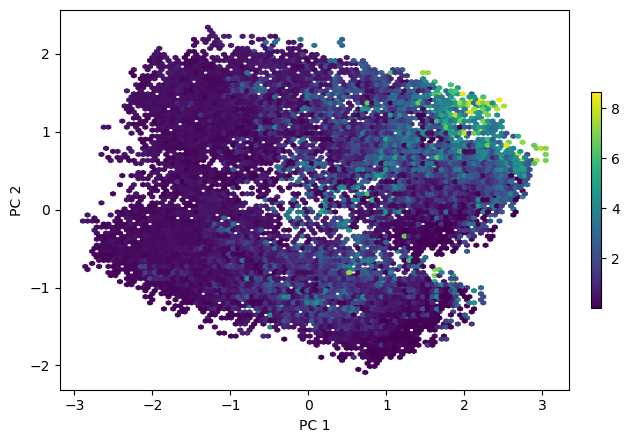

In [18]:
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')
plt.show()

In [19]:
def find_index(input):

    for i, t in enumerate(X):
        if np.array_equal(t, input):
            return i
    return None

def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

In [20]:
unique_ids = []

for i in range(len(all_positions)):
    ids_acquired = all_positions[i]
    for j in all_positions[i]:
        if j not in unique_ids:
            unique_ids.append(j)

    print(ids_acquired)

print(unique_ids)


print("Black Box Function calls: ", len(unique_ids))
print("All_function_calls: ", len(all_function_calls))

[8030, 8030, 8030, 8030, 8030, 8030, 8030, 8030, 8030, 8030, 8030]
[19190, 22086, 22046, 21690, 21690, 21690, 21690, 21690, 21690, 21690, 21690]
[7558, 7558, 7558, 7558, 7558, 7558, 7558, 7558, 7558, 7558, 7558]
[17777, 17777, 17777, 17777, 17777, 17777, 17777, 17777, 17777, 17777, 17777]
[2511, 2511, 2511, 2511, 2511, 2511, 2511, 2511, 2511, 2511, 2511]
[14173, 14485, 14391, 14391, 14391, 14490, 10981, 2511, 2511, 2511, 2511]
[3521, 3521, 3521, 3521, 3521, 3521, 3521, 3521, 3521, 3521, 3521]
[18099, 18099, 17170, 18524, 18524, 18524, 18524, 18524, 18524, 18524, 18524]
[20626, 21096, 21096, 21096, 21096, 21096, 21096, 21096, 21096, 21096, 21096]
[8897, 6845, 6845, 6845, 6845, 6845, 6845, 6845, 6845, 6845, 6845]
[8030, 19190, 22086, 22046, 21690, 7558, 17777, 2511, 14173, 14485, 14391, 14490, 10981, 3521, 18099, 17170, 18524, 20626, 21096, 8897, 6845]
Black Box Function calls:  21
All_function_calls:  21


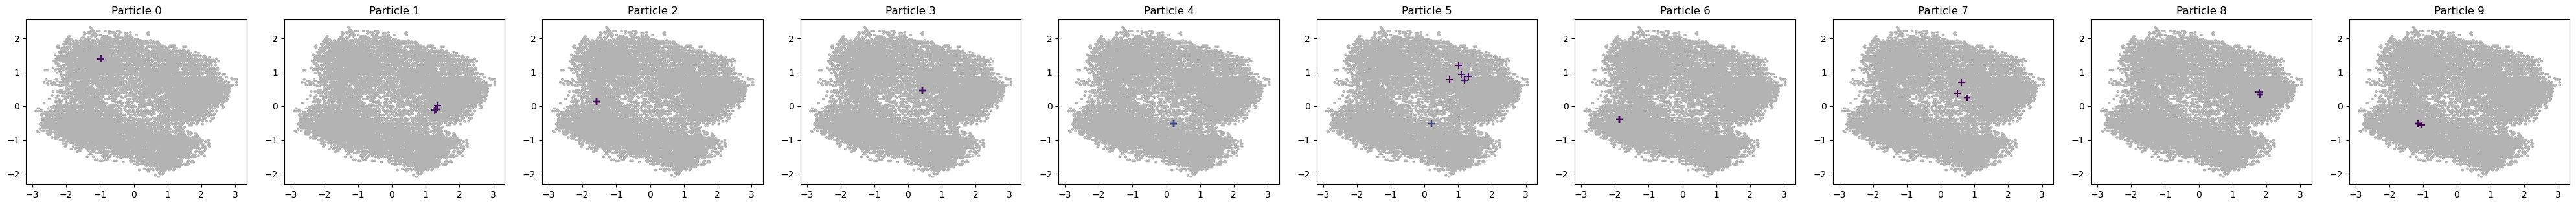

In [21]:
fig, ax = plt.subplots(1, num_particles, figsize=[40, 40])
fig.tight_layout()

for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range(num_particles):
    ids_acquired = all_positions[i]
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Particle {}'.format(i))

#plt.savefig("feature_space_acquired_MOFs.pdf", bbox_inches="tight")
plt.show()


0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]
0.9999999999999998
[1111, 2949, 4311, 2222, 2222]


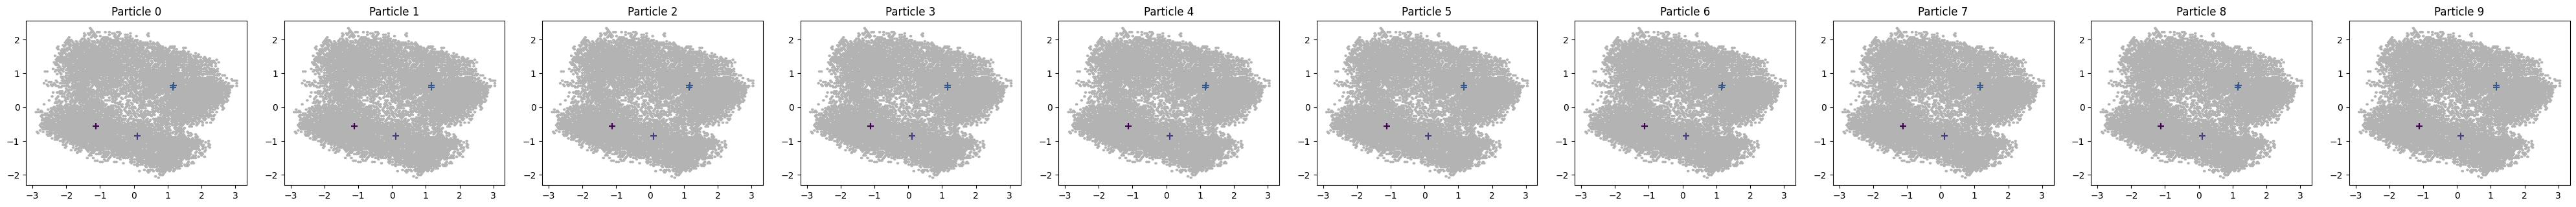

In [62]:
fig, ax = plt.subplots(1, num_particles, figsize=[40, 40])
fig.tight_layout()

for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range(num_particles):
    init_position = 1111
    final_position = 2222
    ids_acquired = [init_position]
    difference = X[final_position] - X[init_position]
    difference = (difference / np.linalg.norm(difference))
    print(np.linalg.norm(difference))
    ids_acquired.append( closest_index(X[init_position] + difference) )
    ids_acquired.append( closest_index(X[init_position] + (2.0 * difference)) )
    ids_acquired.append( closest_index(X[init_position] + (3.0 * difference)) )
    ids_acquired.append( closest_index(X[init_position] + (4.0 * difference)) )

    print(ids_acquired)


    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Particle {}'.format(i))

#plt.savefig("feature_space_acquired_MOFs.pdf", bbox_inches="tight")
plt.show()

[[4647, 5515, 9959, 9922, 9922, 9922, 9959, 9959, 9959, 9959, 9959], [17773, 17773, 17773, 9922, 9959, 9959, 9959, 9959, 9959, 9959, 9959], [9887, 9887, 9887, 9959, 9922, 9922, 9959, 9959, 9959, 9959, 9959], [4908, 4908, 4908, 7798, 9922, 9922, 9922, 9922, 9922, 9922, 9922], [7760, 9922, 9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959], [7397, 9959, 9922, 9922, 9922, 9922, 9922, 9922, 9959, 9959, 9959], [3626, 9959, 9922, 9922, 9922, 9959, 9959, 9959, 9959, 9959, 9959], [6561, 8986, 12565, 9959, 9922, 9922, 9959, 9959, 9959, 9959, 9959], [10723, 9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959], [9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959, 9959]]
[4647, 17773, 9887, 4908, 7760, 7397, 3626, 6561, 10723, 9959]
[5515, 17773, 9887, 4908, 9922, 9959, 9959, 8986, 9959, 9959]
[9959, 17773, 9887, 4908, 9959, 9922, 9922, 12565, 9959, 9959]
[9922, 9922, 9959, 7798, 9959, 9922, 9922, 9959, 9959, 9959]
[9922, 9959, 9922, 9922, 9959, 9922, 9922, 9922, 9959, 9959]
[992

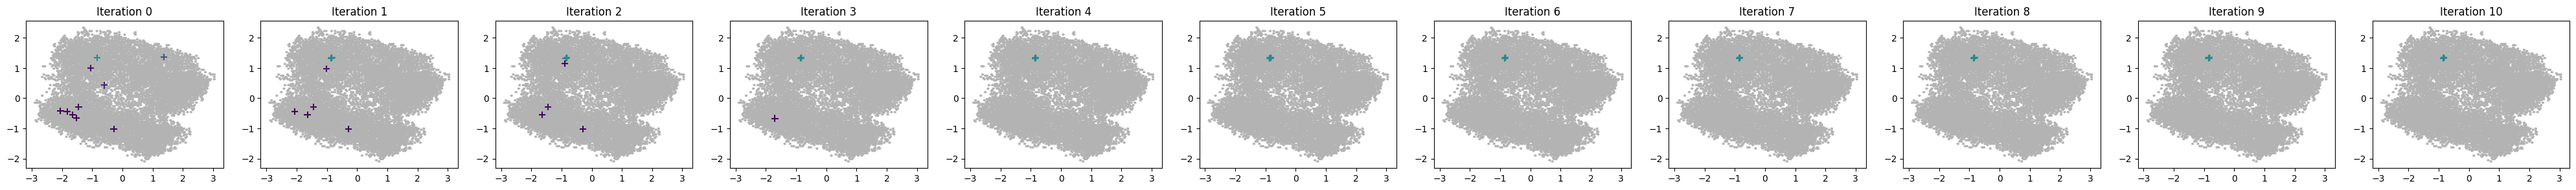

In [48]:
fig, ax = plt.subplots(1, len(all_positions[0]), figsize=(40, 40))
fig.tight_layout()
print(all_positions)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range(len(all_positions[0])):
    ids_acquired = [id[i] for id in all_positions]
    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Iteration {}'.format(i))

#plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


[0.392732345, 0.392732345, 0.392732345, 0.505413332, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826, 1.952585826]


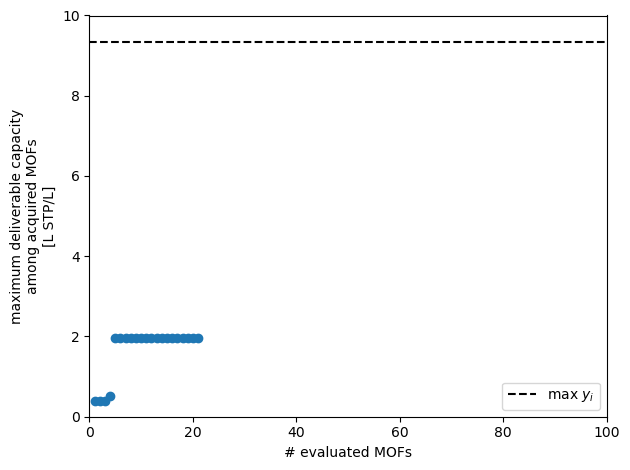

In [22]:
x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(global_max_per_function_call)

plt.figure()
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
# We now have to run PSO many times to find an average rate of optimization
# We will also measure the time taken for each of the optimization techniques to run!
import time

num_particles = 20
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w = 2.0
c1 = 1.0
c2 = 1.0
num_iterations = 10

nb_runs = 50  # Number of runs of this we're doing!

gmpfc_arr = []
apt_arr = []
time_elapsed_per_run = []

for run_no in range(nb_runs):
    print("Run # ", run_no)

    start_time = time.time()

    initial_positions_PSO = random.choices(X, k=num_particles)
    #print("Initial Position for Run No. ", run_no, ": ", initial_positions_PSO)
    pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, initial_positions_PSO)
    best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Run # ",  run_no, " completed in ", elapsed_time, " seconds!")
    time_elapsed_per_run.append(elapsed_time)

    print("best_fitness for Run No. ", run_no, ": ", best_fitness)
    gmpfc_arr.append(global_max_per_function_call)
    apt_arr.append(all_function_calls)

print(time_elapsed_per_run)
print(gmpfc_arr)
print(apt_arr)

Run #  0
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Run #  0  completed in  12.782297134399414  seconds!
best_fitness for Run No.  0 :  7.875021518
Run #  1
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Run #  1  completed in  12.678972721099854  seconds!
best_fitness for Run No.  1 :  4.850975184
Run #  2
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Run #  2  completed in  12.720476627349854  seconds!
best_fitness for Run No.  2 :  8.638420877
Run #  3
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Run #  3  completed in  12.821677207946777  seconds!
best_fitness for Run No.  3 :  7.182975623
Run #  4
Iteration #

Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Run #  33  completed in  12.690597534179688  seconds!
best_fitness for Run No.  33 :  7.620388573
Run #  34
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Run #  34  completed in  12.555685758590698  seconds!
best_fitness for Run No.  34 :  4.795768512
Run #  35
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Run #  35  completed in  12.680654287338257  seconds!
best_fitness for Run No.  35 :  7.932637915
Run #  36
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Run #  36  completed in  12.768126726150513  seconds!
best_fitness for Run No.  36 :  7.421343448
Run #  37
Iteration # 0
Iteration # 1
Iteration # 2
Iteratio

In [ ]:
# Dumping this data into a .pkl file:
with open('pso_graph_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr, 'time_elapsed_per_run': time_elapsed_per_run}, file)

In [ ]:
gmpfc_arr = pickle.load(open('pso_graph_results.pkl', 'rb'))['gmpfc_arr']
apt_arr = pickle.load(open('pso_graph_results.pkl', 'rb'))['apt_arr']

In [ ]:
num_iterations_per_run = []
for i in range(len(gmpfc_arr)):
    num_iterations_per_run.append(len(gmpfc_arr[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[55, 51, 56, 51, 69, 56, 45, 61, 71, 49, 68, 53, 49, 58, 50, 43, 42, 58, 60, 44, 78, 46, 56, 69, 81, 46, 38, 42, 75, 50, 32, 43, 42, 49, 42, 54, 41, 46, 57, 39, 66, 64, 55, 37, 59, 62, 40, 50, 54, 50]
81


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(max_num_iterations):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes.append(gmpfc_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [0.461415749, 0.138958995, 2.331349693, 0.416318159, 0.021679659, 0.048739102, 3.244129152, 0.062050969, 0.640333274, 0.748569405, 3.591139913, 0.367521522, 0.068030747, 0.034983953, 0.04902821, 0.632189721, 0.052841937, 0.647027202, 0.548816838, 0.508177684, 0.021405814, 0.140386482, 0.038629051, 0.183787755, 4.158791122, 0.660818692, 4.009097473, 0.540167585, 4.009097473, 0.167039404, 0.389616352, 0.7635213, 0.004771497, 2.86094854, 0.669593919, 0.141059697, 0.152538804, 0.176966227, 0.040735561, 0.471623797, 3.742366235, 0.679574705, 0.12328239, 0.000774054, 0.612603335, 0.584617162, 0.039688042, 0.085357832, 0.236253238, 3.545835634]
y_max_mu[i]:  0.8772850211200001
y_maxes < y_max_mu[i]:  [ True  True False  True  True  True False  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True False  True False  True  True  True  True False  True  True
  True  True  True  True False  True  True  True  

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
ids_to_rank = np.argsort(y.squeeze())
print(ids_to_rank)

[22796 22084 22974 ... 20581  7486 21275]


In [ ]:
top_100_COF_ids = np.flip(np.argsort(y))[:100]
assert np.size(top_100_COF_ids) == 100
print("top 100 COFs range from y =", np.min(y[top_100_COF_ids]), "to", np.max(y[top_100_COF_ids]))

top 100 COFs range from y = 7.371122512 to 9.55440106


In [ ]:
def fraction_in_top100_cofs(ids_acquired):
    nb_in_top_100 = 0
    for id_acquired in ids_acquired:
        if id_acquired in top_100_COF_ids:
            nb_in_top_100 += 1
    return nb_in_top_100 / 100

In [ ]:
# get fraction of aquired COFs in top 100 for
def y_top_100(arr):
    y_top100_mu      = np.zeros(max_num_iterations)

    for i in range(max_num_iterations):
        y_ranks = []

        for j in range(nb_runs):
            temp = []
            if ( i < len(arr[j]) ): #only if arr[] has ith function call!
                for k in range(i):
                    temp.append(arr[j][k])
            else:
                temp = arr[j]

            y_ranks.append(temp)

        y_frac_top_100_per_run = []
        for l in y_ranks:
            y_frac_top_100_per_run.append(fraction_in_top100_cofs(l))


        np_y_frac_top_100_per_run = np.array(y_frac_top_100_per_run)

        y_top100_mu[i] = np.mean(np_y_frac_top_100_per_run)


    return y_top100_mu


y_top100_mu_pso = y_top_100(apt_arr)
print(y_top100_mu_pso)


[0.     0.     0.     0.     0.     0.     0.     0.0002 0.0002 0.0002
 0.0002 0.0002 0.0004 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006
 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006
 0.0008 0.001  0.001  0.001  0.001  0.0012 0.0012 0.0012 0.0012 0.0012
 0.0012 0.0012 0.0012 0.0012 0.0016 0.002  0.002  0.0022 0.0024 0.0028
 0.0028 0.003  0.003  0.0034 0.0036 0.0036 0.0038 0.0038 0.004  0.004
 0.004  0.0042 0.0044 0.0044 0.0046 0.0048 0.005  0.005  0.005  0.005
 0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.0052 0.0054 0.0054
 0.0054]


In [ ]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81]


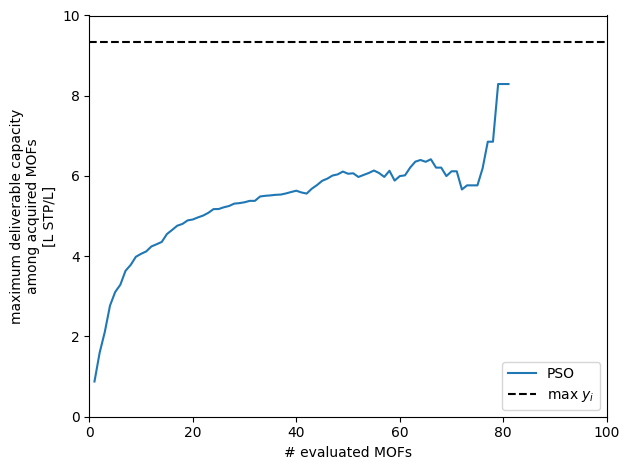

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
with open('pso_graph_outputs.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_pso': y_max_mu, 'y_max_sig_bot_pso': y_max_sig_bot, 'y_max_sig_top_pso': y_max_sig_top}, file)

In [ ]:
# We're going to "fix" the non-monotonicity of the PSO graph now, by adding dummy samples
gmpfc_arr_fixed = (pickle.load ( open ( 'pso_graph_results.pkl', 'rb' ) ) [ 'gmpfc_arr' ] )
apt_arr_fixed = (pickle.load(open('pso_graph_results.pkl', 'rb'))['apt_arr'])

In [ ]:
print(len(gmpfc_arr_fixed))

50


In [ ]:
num_iterations_per_run = []
for i in range(50):
    num_iterations_per_run.append(len(gmpfc_arr_fixed[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[55, 51, 56, 51, 69, 56, 45, 61, 71, 49, 68, 53, 49, 58, 50, 43, 42, 58, 60, 44, 78, 46, 56, 69, 81, 46, 38, 42, 75, 50, 32, 43, 42, 49, 42, 54, 41, 46, 57, 39, 66, 64, 55, 37, 59, 62, 40, 50, 54, 50]
81


In [ ]:
for i in range(50):
    if (len(gmpfc_arr_fixed[i]) < max_num_iterations):
        for j in range(max_num_iterations - len(gmpfc_arr_fixed[i])):
            gmpfc_arr_fixed[i].append(gmpfc_arr_fixed[i][len(gmpfc_arr_fixed[i]) - 1])


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu_fixed = []
y_max_sig_bot_fixed = []
y_max_sig_top_fixed = []

for i in range(max_num_iterations):
    y_maxes_fixed = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr_fixed[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes_fixed.append(gmpfc_arr_fixed[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes_fixed)
    y_max_mu_fixed.append( np.mean(y_maxes_fixed) )
    print("y_max_mu_fixed[i]: ", y_max_mu_fixed[i])
    print("y_maxes_fixed < y_max_mu_fixed[i]: ", y_maxes_fixed < y_max_mu_fixed[i])

    y_maxes_L_y_max_mu_i_fixed = y_maxes_fixed < y_max_mu_fixed[i]
    y_max_sig_bot_temp_fixed = []
    for k in range(len(y_maxes_L_y_max_mu_i_fixed)):
        if (y_maxes_L_y_max_mu_i_fixed[k] == True):
            y_max_sig_bot_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_bot_fixed.append( np.std ( y_max_sig_bot_temp_fixed )  )
    print(y_max_sig_bot_fixed[i])

    y_maxes_G_y_max_mu_i_fixed = y_maxes_fixed > y_max_mu_fixed[i]
    y_max_sig_top_temp_fixed = []
    for k in range(len(y_maxes_G_y_max_mu_i_fixed)):
        if (y_maxes_G_y_max_mu_i_fixed[k] == True):
            y_max_sig_top_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_top_fixed.append( np.std ( y_max_sig_top_temp_fixed )  )
    print(y_max_sig_top_fixed[i])

print("y_max_mu_fixed: ", y_max_mu_fixed)
print("y_max_sig_bot_fixed: ", y_max_sig_bot_fixed)
print("y_max_sig_top_fixed: ", y_max_sig_top_fixed)


y_maxes for iteration  0 :  [0.461415749, 0.138958995, 2.331349693, 0.416318159, 0.021679659, 0.048739102, 3.244129152, 0.062050969, 0.640333274, 0.748569405, 3.591139913, 0.367521522, 0.068030747, 0.034983953, 0.04902821, 0.632189721, 0.052841937, 0.647027202, 0.548816838, 0.508177684, 0.021405814, 0.140386482, 0.038629051, 0.183787755, 4.158791122, 0.660818692, 4.009097473, 0.540167585, 4.009097473, 0.167039404, 0.389616352, 0.7635213, 0.004771497, 2.86094854, 0.669593919, 0.141059697, 0.152538804, 0.176966227, 0.040735561, 0.471623797, 3.742366235, 0.679574705, 0.12328239, 0.000774054, 0.612603335, 0.584617162, 0.039688042, 0.085357832, 0.236253238, 3.545835634]
y_max_mu_fixed[i]:  0.8772850211200001
y_maxes_fixed < y_max_mu_fixed[i]:  [ True  True False  True  True  True False  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True False  True False  True  True  True  True False  True  True
  True  True  True  True False  

In [ ]:
np_y_max_mu_fixed = np.array(y_max_mu_fixed)
np_y_max_sig_bot_fixed = np.array(y_max_sig_bot_fixed)
np_y_max_sig_top_fixed = np.array(y_max_sig_top_fixed)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81]


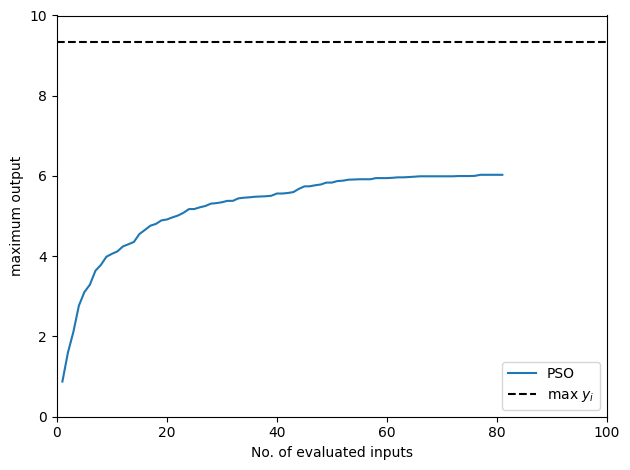

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu_fixed, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu_fixed - np_y_max_sig_bot_fixed, np_y_max_mu_fixed + np_y_max_sig_top_fixed, alpha=0.2, ec="None")

plt.xlabel('No. of evaluated inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()

In [ ]:
# Dumping these values into a .pkl file to be opened in Visualizations.ipynb
with open('pso_graph_outputs_fixed.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_pso_fixed': y_max_mu_fixed, 'y_max_sig_bot_pso_fixed': y_max_sig_bot_fixed, 'y_max_sig_top_pso_fixed': y_max_sig_top_fixed}, file)

In [ ]:
# Let's compare PSO with BO:
max_per_function_call_arr = (pickle.load ( open ( 'bo_results.pkl', 'rb' ) ) [ 'max_per_function_call_arr' ] )
ids_acquired_arr = (pickle.load(open('bo_results.pkl', 'rb'))['ids_acquired_arr'])

In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(nb_runs):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(max_per_function_call_arr[j]) ): #only if max_per_function_call_arr[j] has ith iteration!
              y_maxes.append(max_per_function_call_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [3.063389122, 4.156399939, 0.720559008, 3.518540556, 3.227043247, 6.589508562, 1.315834979, 3.86937371, 4.267187623, 3.797422844, 3.64083087, 3.912508441, 4.204993743, 6.237292096, 8.114828365, 4.42266986, 1.391680639, 3.321868869, 3.294253447, 4.786863746, 6.576700296, 2.338506113, 2.879615172, 2.84951143, 2.471981872, 4.220139993, 6.183734783, 7.008421897, 4.269682958, 4.496194097, 3.577902957, 3.490982915, 0.67823605, 0.598061412, 4.489595362, 2.30690692, 2.375171313, 6.300649253, 3.353004959, 3.620244832, 0.642777515, 3.474303089, 5.721445482, 3.200858557, 3.415592296, 4.495289718, 6.232734876, 3.890345113, 6.686438756, 1.141334023]
y_max_mu[i]:  3.8167882735000007
y_maxes < y_max_mu[i]:  [ True False  True  True  True False  True False False  True  True False
 False False False False  True  True  True False False  True  True  True
  True False False False False False  True  True  True  True False  True
  True False  True  True  True  True False  True  T

In [ ]:
np_y_max_mu_bo = np.array(y_max_mu)
np_y_max_sig_bot_bo = np.array(y_max_sig_bot)
np_y_max_sig_top_bo = np.array(y_max_sig_top)

In [ ]:
y_max_mu_epso_fixed = (pickle.load ( open ( 'epso_graph_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_mu_epso_fixed' ] )
#ids_acquired_arr = (pickle.load(open('epso_graph_outputs_fixed.pkl', 'rb'))['ids_acquired_arr'])

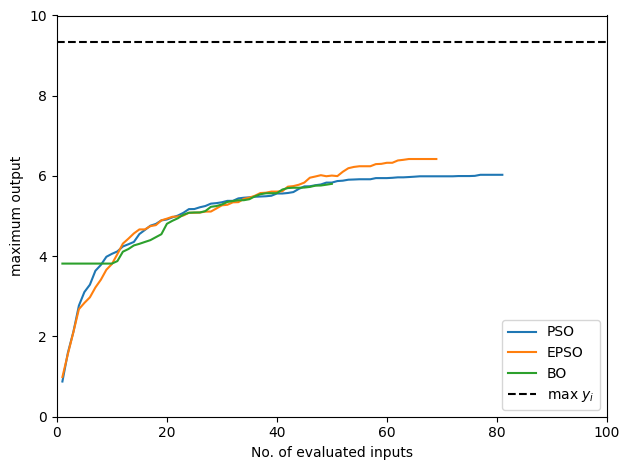

In [ ]:
x_values_pso = np.arange(1, max_num_iterations + 1)
x_values_epso = np.arange(1, 70)
x_values_bo = np.arange(1, 51)

plt.figure()
plt.plot(x_values_pso, y_max_mu_fixed, label="PSO", clip_on=False)
plt.plot(x_values_epso, y_max_mu_epso_fixed, label="EPSO", clip_on=False)
plt.plot(x_values_bo, np_y_max_mu_bo, label="BO", clip_on=False)

#plt.fill_between(max_num_iterations, np_y_max_mu_fixed - np_y_max_sig_bot_fixed, np_y_max_mu_fixed + np_y_max_sig_top_fixed, alpha=0.2, ec="None")

plt.xlabel('No. of evaluated inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()

In [ ]:
# Modified PSO for velocity profile

def objective_function(x):
    x = np.array(x)

    # Finding the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    return y[closest_index]

# snap_position essentially snaps the input to the point in the database closest to it
def snap_position(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    snapped_input = X[closest_index]
    return snapped_input

def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

class Particle:
    def __init__(self, num_dimensions, lower_bound, upper_bound, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.best_position)
        self.index = index
        self.positions_traversed = [closest_index(init_position)]

class PSO:
    def __init__(self, num_particles, num_dimensions, lower_bound, upper_bound, w, c, num_iterations, init_positions):
        self.num_particles = num_particles
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w = w
        self.c = c
        self.num_iterations = num_iterations
        self.particles = [Particle(num_dimensions, lower_bound, upper_bound, init_positions[ind], ind) for ind in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].position)
        self.global_best_fitness = self.particles[0].best_fitness
        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []
        init_pos_max = -1.0
        init_position_max = np.copy(self.particles[0].position)
        for init_pos in init_positions:
            self.unique_function_call_ids.append(closest_index(init_pos))
            if (y[closest_index(init_pos)] > init_pos_max):
                init_position_max = np.copy(init_pos)
                init_pos_max = y[closest_index(init_pos)]
            self.global_max_for_each_unique_function_call.append(init_pos_max)

        self.global_best_position = np.copy(init_position_max)
        self.global_best_fitness = init_pos_max

    def update_particles(self):

        velocity_weights = []
        best_positions = []
        # Computing the new velocitiy profile
        for particle in self.particles:
            velocity_weights.append(particle.best_fitness)
            best_positions.append(particle.best_position)

        for particle in self.particles:
            # Update velocities
            particle.velocity = self.w * particle.velocity
            for i in range(len(velocity_weights)):
                particle.velocity = particle.velocity + ((self.c * velocity_weights[i]) * (best_positions[i] - particle.position))

            if(np.linalg.norm(particle.velocity) > 1.5):
                print("old norm: ", np.linalg.norm(particle.velocity))
                particle.velocity = ((particle.velocity / np.linalg.norm(particle.velocity)) * 1.5)
                print("new norm: ", np.linalg.norm(particle.velocity))

            particle.position = particle.position + particle.velocity

            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = snap_position(particle.position)
            particle.positions_traversed.append(closest_index(particle.position))

    def update_personal_and_global_bests(self):
        for particle in self.particles:
            unique_function_called = False
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
                unique_function_called = True
            current_fitness = objective_function(particle.position)

            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                if current_fitness > self.global_best_fitness:
                    self.global_best_position = np.copy(particle.position)
                    self.global_best_fitness = current_fitness

            if (unique_function_called == True):
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

    def optimize(self):
        for particle in self.particles:
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
            if particle.best_fitness > self.global_best_fitness:
                self.global_best_position = np.copy(particle.position)
                self.global_best_fitness = particle.best_fitness
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

        for i in range(self.num_iterations):
            self.update_particles()
            self.update_personal_and_global_bests()

        all_positions_traversed = []

        for particle in self.particles:
            all_positions_traversed.append(particle.positions_traversed)


        return self.global_best_position, self.global_best_fitness, all_positions_traversed, self.unique_function_call_ids, self.global_max_for_each_unique_function_call

# Example usage
num_particles = 10
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w = 1.0
c = 1.0
num_iterations = 10

initial_positions_PSO = random.choices(X, k=num_particles)
print(initial_positions_PSO)


pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions: ", all_positions)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)


[array([1.        , 0.00404331, 0.        , 0.10930183, 0.08786805,
       0.00251624, 0.16666667, 0.51565105, 0.47041303, 0.44104013,
       0.42914933, 0.42031356, 0.28494624, 0.41935484, 0.43820225,
       0.49462366, 0.07526882, 0.28494624, 0.75      , 0.22680412,
       0.23157895, 0.85148515, 0.64      , 0.75      , 0.2507319 ,
       0.37807326, 0.39396713, 0.43976853, 0.06169527, 0.2507319 ,
       0.16562265, 0.30982754, 0.31318136, 0.32053642, 0.01070888,
       0.16562265, 0.73529412, 0.29411765, 0.3125    , 0.88235294,
       0.58823529, 0.73529412, 0.41666667, 0.5       , 0.5625    ,
       0.66666667, 0.16666667, 0.41666667, 0.34976526, 0.37089202,
       0.37089202, 0.53521127, 0.16431925, 0.34976526, 0.59404389,
       0.47335423, 0.47335423, 0.830721  , 0.35736677, 0.59404389,
       0.71666667, 0.5       , 0.5       , 1.        , 0.5       ,
       0.75      , 0.33333333, 0.66666667, 0.8       , 0.66666667,
       0.        , 0.33333333, 0.5       , 1.        , 1.    

In [ ]:
def find_index(input):

    for i, t in enumerate(X):
        if np.array_equal(t, input):
            return i
    return None

def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

In [ ]:
unique_ids = []

for i in range(len(all_positions)):
    ids_acquired = all_positions[i]
    for j in all_positions[i]:
        if j not in unique_ids:
            unique_ids.append(j)

    print(ids_acquired)

print(unique_ids)


print("Black Box Function calls: ", len(unique_ids))
print("All_function_calls: ", len(all_function_calls))

[1161, 12819, 18645, 16371, 12741, 16371, 18645, 16371, 16371, 18645, 16371]
[2269, 8129, 14705, 17118, 13968, 16371, 18645, 16371, 16371, 18645, 16371]
[18327, 16618, 17118, 18209, 16371, 17118, 16371, 16371, 18645, 16371, 16371]
[7366, 7366, 7366, 7366, 7366, 11489, 15226, 15226, 15226, 15226, 15226]
[22738, 17118, 18645, 16371, 12741, 16371, 18645, 16371, 16371, 18645, 16371]
[22633, 17307, 17118, 18209, 16371, 17118, 16371, 16371, 18645, 16371, 16371]
[13705, 13705, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039]
[20171, 13676, 17118, 18209, 16371, 17118, 16371, 16371, 18645, 16371, 16371]
[17100, 19612, 17118, 18209, 16371, 17118, 16371, 16371, 18645, 16371, 16371]
[23741, 18645, 17118, 12741, 16371, 18645, 16371, 16371, 18645, 16371, 16371]
[1161, 12819, 18645, 16371, 12741, 2269, 8129, 14705, 17118, 13968, 18327, 16618, 18209, 7366, 11489, 15226, 22738, 22633, 17307, 13705, 1039, 20171, 13676, 17100, 19612, 23741]
Black Box Function calls:  26
All_function_calls:  26


[[1161, 12819, 18645, 16371, 12741, 16371, 18645, 16371, 16371, 18645, 16371], [2269, 8129, 14705, 17118, 13968, 16371, 18645, 16371, 16371, 18645, 16371], [18327, 16618, 17118, 18209, 16371, 17118, 16371, 16371, 18645, 16371, 16371], [7366, 7366, 7366, 7366, 7366, 11489, 15226, 15226, 15226, 15226, 15226], [22738, 17118, 18645, 16371, 12741, 16371, 18645, 16371, 16371, 18645, 16371], [22633, 17307, 17118, 18209, 16371, 17118, 16371, 16371, 18645, 16371, 16371], [13705, 13705, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039], [20171, 13676, 17118, 18209, 16371, 17118, 16371, 16371, 18645, 16371, 16371], [17100, 19612, 17118, 18209, 16371, 17118, 16371, 16371, 18645, 16371, 16371], [23741, 18645, 17118, 12741, 16371, 18645, 16371, 16371, 18645, 16371, 16371]]
[1161, 2269, 18327, 7366, 22738, 22633, 13705, 20171, 17100, 23741]
[12819, 8129, 16618, 7366, 17118, 17307, 13705, 13676, 19612, 18645]
[18645, 14705, 17118, 7366, 18645, 17118, 1039, 17118, 17118, 17118]
[16371, 17118, 18209

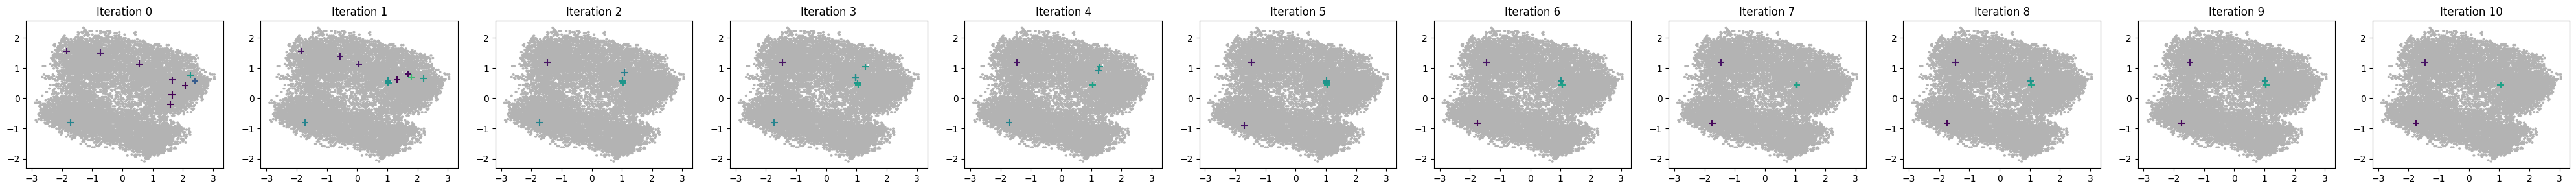

In [ ]:
fig, ax = plt.subplots(1, len(all_positions[0]), figsize=(40, 40))
fig.tight_layout()
print(all_positions)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range(len(all_positions[0])):
    ids_acquired = [id[i] for id in all_positions]
    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Iteration {}'.format(i))

plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


[0.272821273, 0.534112913, 0.534112913, 3.922203356, 3.922203356, 3.922203356, 3.922203356, 3.922203356, 4.654737659, 4.654737659, 4.654737659, 4.654737659, 4.654737659, 4.654737659, 5.997497468, 5.997497468, 5.997497468, 5.997497468, 5.997497468, 5.997497468, 5.997497468, 5.997497468, 5.997497468, 5.997497468, 5.997497468, 5.997497468]


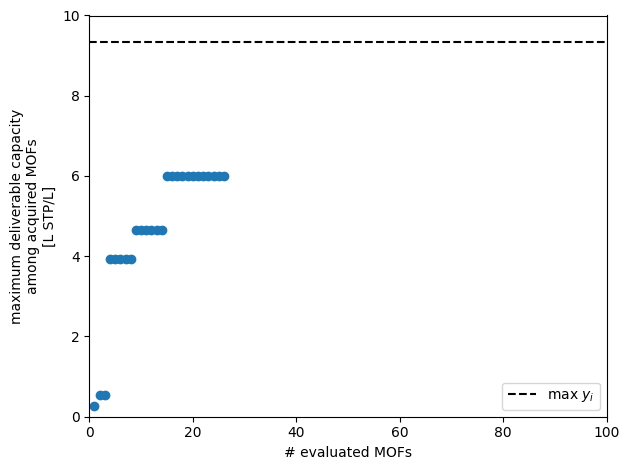

In [ ]:
x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(global_max_per_function_call)

plt.figure()
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
# We now have to run our velocity profile PSO many times to find an average rate of optimization

num_particles = 20
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w = 1.0
c1 = 10.0
num_iterations = 10

nb_runs = 50  # Number of runs of this we're doing!

gmpfc_arr = []
apt_arr = []

for run_no in range(nb_runs):
    print("Run No.: ", run_no)
    initial_positions_PSO = random.choices(X, k=num_particles)
    print("Initial Position for Run No. ", run_no, ": ", initial_positions_PSO)
    pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c, num_iterations, initial_positions_PSO)
    best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()
    print("best_fitness for Run No. ", run_no, ": ", best_fitness)
    gmpfc_arr.append(global_max_per_function_call)
    apt_arr.append(all_function_calls)

print(gmpfc_arr)
print(apt_arr)

Streaming output truncated to the last 5000 lines.
       5.35714286e-01, 5.35714286e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.33333333e-01, 4.00000000e-01, 2.22222222e-01, 4.00000000e-01,
       0.00000000e+00, 4.00000000e-01, 1.48148148e-01, 8.88888889e-01,
       4.93827160e-01, 8.88888889e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.36363636e-01, 2.72727273e-01,
       1.51515152e-01, 3.63636364e-01, 9.09090909e-02, 9.09090909e-02,
       2.45443309e-01, 1.14082482e-01, 6.33791567e-02, 2.64457056e-01,
       1.50374574e-01, 2.64457056e-01, 4.92380832e-02, 5.90856997e-02,
       3.28253888e-02, 5.90856997e-02, 0.00000000e+00, 5.90856997e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.91629956e-01, 1.85022026e-01,
       1.02790015e-01, 8.4

In [ ]:
# Dumping this data into a .pkl file:
with open('pso_vel_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr}, file)

In [ ]:
num_iterations_per_run = []
for i in range(50):
    num_iterations_per_run.append(len(gmpfc_arr[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[45, 46, 58, 55, 53, 60, 59, 59, 78, 53, 58, 52, 43, 51, 49, 56, 40, 67, 46, 47, 55, 45, 47, 49, 60, 52, 52, 38, 59, 52, 51, 54, 56, 43, 59, 54, 48, 58, 61, 54, 48, 66, 50, 50, 49, 56, 59, 52, 44, 64]
78


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(max_num_iterations):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes.append(gmpfc_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [1.938083557, 0.233270137, 0.020407449, 0.021459438, 1.008495951, 0.01198797, 0.393932564, 0.036053071, 0.242372751, 0.563442489, 0.004163016, 0.357214449, 0.097864562, 0.469808372, 0.022797428, 2.097576703, 0.417431449, 0.427483946, 3.07330187, 0.64602389, 0.522061796, 2.236731447, 0.443782907, 0.516493111, 2.33467638, 0.095765024, 7.074853104, 0.032685839, 0.471544679, 0.000749154, 4.957962399, 0.127765714, 0.173267755, 0.000519227, 0.060610958, 0.636311275, 0.244936362, 5.154759084, 0.00016227, 0.168835611, 0.010659343, 0.437132787, 0.561484742, 0.099236591, 0.51163922, 0.036196307, 0.077696129, 0.065487266, 0.521165323, 0.236104561]
y_max_mu[i]:  0.79788894854
y_maxes < y_max_mu[i]:  [False  True  True  True False  True  True  True  True  True  True  True
  True  True  True False  True  True False  True  True False  True  True
 False  True False  True  True  True False  True  True  True  True  True
  True False  True  True  True  True  True  True  True  

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78]


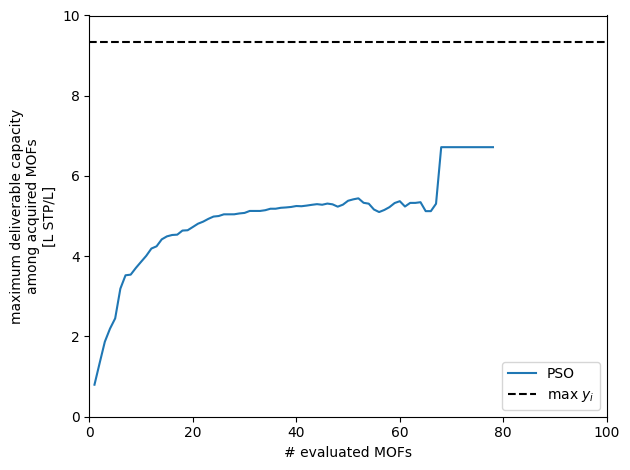

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
# We're going to "fix" the non-monotonicity of the PSO graph now, by adding dummy samples
gmpfc_arr_fixed = (pickle.load ( open ( 'pso_vel_results.pkl', 'rb' ) ) [ 'gmpfc_arr' ] )
apt_arr_fixed = (pickle.load(open('pso_vel_results.pkl', 'rb'))['apt_arr'])

In [ ]:
for i in range(50):
    if (len(gmpfc_arr_fixed[i]) < max_num_iterations):
        for j in range(max_num_iterations - len(gmpfc_arr_fixed[i])):
            gmpfc_arr_fixed[i].append(gmpfc_arr_fixed[i][len(gmpfc_arr_fixed[i]) - 1])


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu_fixed = []
y_max_sig_bot_fixed = []
y_max_sig_top_fixed = []

for i in range(max_num_iterations):
    y_maxes_fixed = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr_fixed[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes_fixed.append(gmpfc_arr_fixed[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes_fixed)
    y_max_mu_fixed.append( np.mean(y_maxes_fixed) )
    print("y_max_mu_fixed[i]: ", y_max_mu_fixed[i])
    print("y_maxes_fixed < y_max_mu_fixed[i]: ", y_maxes_fixed < y_max_mu_fixed[i])

    y_maxes_L_y_max_mu_i_fixed = y_maxes_fixed < y_max_mu_fixed[i]
    y_max_sig_bot_temp_fixed = []
    for k in range(len(y_maxes_L_y_max_mu_i_fixed)):
        if (y_maxes_L_y_max_mu_i_fixed[k] == True):
            y_max_sig_bot_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_bot_fixed.append( np.std ( y_max_sig_bot_temp_fixed )  )
    print(y_max_sig_bot_fixed[i])

    y_maxes_G_y_max_mu_i_fixed = y_maxes_fixed > y_max_mu_fixed[i]
    y_max_sig_top_temp_fixed = []
    for k in range(len(y_maxes_G_y_max_mu_i_fixed)):
        if (y_maxes_G_y_max_mu_i_fixed[k] == True):
            y_max_sig_top_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_top_fixed.append( np.std ( y_max_sig_top_temp_fixed )  )
    print(y_max_sig_top_fixed[i])

print("y_max_mu_fixed: ", y_max_mu_fixed)
print("y_max_sig_bot_fixed: ", y_max_sig_bot_fixed)
print("y_max_sig_top_fixed: ", y_max_sig_top_fixed)


y_maxes for iteration  0 :  [1.938083557, 0.233270137, 0.020407449, 0.021459438, 1.008495951, 0.01198797, 0.393932564, 0.036053071, 0.242372751, 0.563442489, 0.004163016, 0.357214449, 0.097864562, 0.469808372, 0.022797428, 2.097576703, 0.417431449, 0.427483946, 3.07330187, 0.64602389, 0.522061796, 2.236731447, 0.443782907, 0.516493111, 2.33467638, 0.095765024, 7.074853104, 0.032685839, 0.471544679, 0.000749154, 4.957962399, 0.127765714, 0.173267755, 0.000519227, 0.060610958, 0.636311275, 0.244936362, 5.154759084, 0.00016227, 0.168835611, 0.010659343, 0.437132787, 0.561484742, 0.099236591, 0.51163922, 0.036196307, 0.077696129, 0.065487266, 0.521165323, 0.236104561]
y_max_mu_fixed[i]:  0.79788894854
y_maxes_fixed < y_max_mu_fixed[i]:  [False  True  True  True False  True  True  True  True  True  True  True
  True  True  True False  True  True False  True  True False  True  True
 False  True False  True  True  True False  True  True  True  True  True
  True False  True  True  True  True  

In [ ]:
np_y_max_mu_fixed = np.array(y_max_mu_fixed)
np_y_max_sig_bot_fixed = np.array(y_max_sig_bot_fixed)
np_y_max_sig_top_fixed = np.array(y_max_sig_top_fixed)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78]


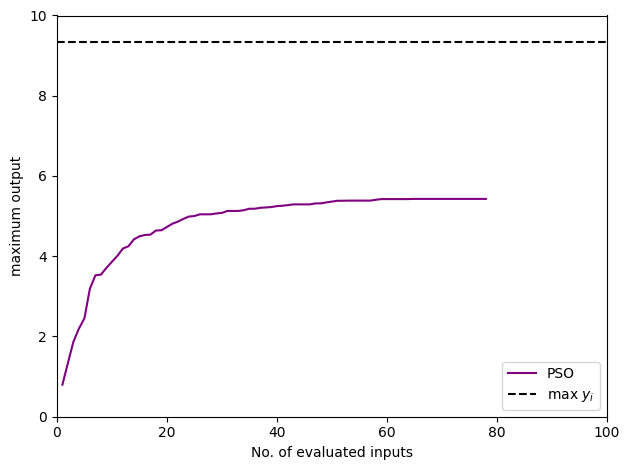

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu_fixed, label="PSO", clip_on=False, color="purple")
plt.fill_between(max_num_iterations, np_y_max_mu_fixed - np_y_max_sig_bot_fixed, np_y_max_mu_fixed + np_y_max_sig_top_fixed, alpha=0.2, ec="None")

plt.xlabel('No. of evaluated inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()